<a href="https://colab.research.google.com/github/robinfwrsg/Houses_price_kathmandu/blob/main/houses_kathmandu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing Folium
!pip install folium

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Setting plot style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/nepal_houses.csv'


In [4]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/nepal_houses.csv')

# Filtering for Kathmandu
df_kathmandu = df[df['City'] == 'Kathmandu'].copy()

# Displaying first 5 rows to understand the data
print("First 5 rows of Kathmandu data:")
print(df_kathmandu.head())

# Displaying dataset info (columns, data types, non-null counts)
print("\nDataset Info:")
print(df_kathmandu.info())

First 5 rows of Kathmandu data:
                                               Title  \
0  Flat System House On Sale At Budhanikantha : H...   
1  21 Aana Beautiful House : House For Sale In Bu...   
2  Beautiful To Floor House : House For Sale In D...   
3  Modern Architecture Bungalow House : House For...   
4  Modern Bungalow House : House For Sale In Golf...   

                                    Address       City      Price  Bedroom  \
0  Budhanikantha, Budhanilkantha, Kathmandu  Kathmandu   90000000        6   
1        Pasikot, Budhanilkantha, Kathmandu  Kathmandu   80000000        5   
2               Dhapasi, Dhapasi, Kathmandu  Kathmandu   70000000        5   
3           baluwatar, Baluwatar, Kathmandu  Kathmandu  130000000        6   
4             Golfutar, Golfutar, Kathmandu  Kathmandu  100000000        6   

   Bathroom  Floors  Parking  Face    Year Views           Area  \
0         3     2.0       10  West  2073.0    17   1-0-0-0 Aana   
1         3     2.0        9

In [5]:
print(df_kathmandu[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking',  'Amenities']].describe())

              Price      Bedroom     Bathroom      Floors      Parking
count  1.483000e+03  1483.000000  1483.000000  728.000000  1483.000000
mean   3.568617e+11     3.008092     2.031018    2.929258     1.119353
std    7.357471e+12     4.522541     2.665896    1.094633     2.255878
min    9.000000e+01     0.000000     0.000000    0.000000     0.000000
25%    2.000000e+06     0.000000     0.000000    2.500000     0.000000
50%    1.400000e+07     2.000000     0.000000    3.000000     0.000000
75%    3.250000e+07     5.000000     4.000000    3.000000     2.000000
max    2.160000e+14    95.000000    40.000000   12.000000    31.000000


In [6]:
def convert_area(area_str):
    if isinstance(area_str, str):
        area_str = area_str.strip()
        try:
            if 'Aana' in area_str:
                parts = area_str.replace(' Aana', '').split('-')
                if len(parts) == 4:
                    ropani, aana, paisa, daam = map(float, parts)
                    total_aana = ropani * 16 + aana + paisa / 4 + daam / 16
                else:
                    total_aana = float(parts[0])
                return total_aana * 342.25
            elif 'Ropani' in area_str:
                parts = area_str.replace(' Ropani', '').split('-')
                if len(parts) == 1:
                    return float(parts[0]) * 5476
                elif len(parts) == 4:
                    ropani, aana, paisa, daam = map(float, parts)
                    total_aana = ropani * 16 + aana + paisa / 4 + daam / 16
                    return total_aana * 342.25
            elif 'Sq. Feet' in area_str:
                return float(area_str.replace(' Sq. Feet', ''))
            elif 'Dhur' in area_str:
                return float(area_str.replace(' Dhur', '')) * 182.25
        except:
            return np.nan
    return np.nan

df_kathmandu['Area_sqft'] = df_kathmandu['Area'].apply(convert_area)
df_kathmandu['Build_Area_sqft'] = df_kathmandu['Build Area'].apply(convert_area)

# Converting Road Width to numeric
df_kathmandu['Road_Width_ft'] = df_kathmandu['Road Width'].str.extract(r'(\d+\.?\d*)').astype(float)

# Extracting numbers with error handling
df_kathmandu['Bedroom'] = df_kathmandu['Bedroom'].astype(str).str.extract(r'(\d+)(?:\s*Bedroom)?')[0].astype(float)
df_kathmandu['Bathroom'] = df_kathmandu['Bathroom'].astype(str).str.extract(r'(\d+)(?:\s*Bathroom)?')[0].astype(float)
df_kathmandu['Floors'] = pd.to_numeric(df_kathmandu['Floors'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')
df_kathmandu['Parking'] = df_kathmandu['Parking'].astype(str).str.extract(r'(\d+)(?:\s*Parking)?')[0].astype(float)

# Filling missing values with median or 0 if median is NaN
for col in ['Bedroom', 'Bathroom', 'Parking']:
    median = df_kathmandu[col].median()
    df_kathmandu[col] = df_kathmandu[col].fillna(median if pd.notna(median) else 0)
# Counting amenities safely
df_kathmandu['Amenities_Count'] = df_kathmandu['Amenities'].apply(
    lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') and x != '[]' else 0
)

# Dropping rows with missing Price
df_kathmandu = df_kathmandu.dropna(subset=['Price'])


In [7]:
# Displaying summary
print("Summary Statistics after Cleaning:")
print(df_kathmandu[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking', 'Area_sqft', 'Build_Area_sqft', 'Road_Width_ft', 'Amenities_Count']].describe())

Summary Statistics after Cleaning:
              Price      Bedroom     Bathroom      Floors      Parking  \
count  1.483000e+03  1483.000000  1483.000000  728.000000  1483.000000   
mean   3.568617e+11     3.008092     2.031018    2.905220     1.119353   
std    7.357471e+12     4.522541     2.665896    1.102991     2.255878   
min    9.000000e+01     0.000000     0.000000    0.000000     0.000000   
25%    2.000000e+06     0.000000     0.000000    2.000000     0.000000   
50%    1.400000e+07     2.000000     0.000000    3.000000     0.000000   
75%    3.250000e+07     5.000000     4.000000    3.000000     2.000000   
max    2.160000e+14    95.000000    40.000000   12.000000    31.000000   

          Area_sqft  Build_Area_sqft  Road_Width_ft  Amenities_Count  
count  1.423000e+03     2.360000e+02    1483.000000      1483.000000  
mean   2.672367e+11     1.468771e+05      14.964262         4.364127  
std    1.008088e+13     1.057007e+06      11.228131         5.836699  
min    0.00000

In [34]:
# Step 1: Cleaning unrealistic prices FIRST
df_kathmandu_clean = df_kathmandu[df_kathmandu['Price'] >= 500000].copy()
print(f"Original data: {len(df_kathmandu)} properties")
print(f"After removing unrealistic prices: {len(df_kathmandu_clean)} properties")
print(f"Removed: {len(df_kathmandu) - len(df_kathmandu_clean)} properties")

# Step 2: cleaning the other columns using the cleaned dataset
for col in ['Bathroom', 'Floors', 'Parking']:  # Leave out Bedroom for custom handling
    non_zero_median = df_kathmandu_clean.loc[df_kathmandu_clean[col] > 0, col].median()
    df_kathmandu_clean[col] = df_kathmandu_clean[col].replace(0, non_zero_median)

# Custom handling for Bedroom
valid_bedroom_values = df_kathmandu_clean.loc[df_kathmandu_clean['Bedroom'] > 0, 'Bedroom']
zero_count = sum(df_kathmandu_clean['Bedroom'] == 0)

if zero_count > 0:  # Only if there are zeros to replace
    replacement_values = np.random.choice(valid_bedroom_values, size=zero_count, replace=True)
    df_kathmandu_clean.loc[df_kathmandu_clean['Bedroom'] == 0, 'Bedroom'] = replacement_values

df_model = df_kathmandu_clean.copy()

# Dropping columns with excessive missing data
df_model = df_model.drop(['Build_Area_sqft', 'Year'], axis=1)

# Handling remaining missing data and outliers
floors_median = df_model['Floors'].median()
df_model['Floors'].fillna(floors_median, inplace=True)

if 'Road Type' in df_model.columns and df_model['Road Type'].dtype == 'object':
    df_model['Road Type'].fillna('Unknown', inplace=True)

df_model.loc[df_model['Parking'] > 10, 'Parking'] = 10

# Capping unrealistic road widths
df_model.loc[df_model['Road_Width_ft'] > 50, 'Road_Width_ft'] = 50

road_width_median = df_model.loc[df_model['Road_Width_ft'] > 0, 'Road_Width_ft'].median()
df_model.loc[df_model['Road_Width_ft'] == 0, 'Road_Width_ft'] = road_width_median

# Removing the extreme high-price outlier
df_model = df_model[~((df_model['Price'] > 100000000) & (df_model['Area_sqft'] < 2000))]

#removing properties with unrealistically low price per sq ft
price_per_sqft = df_model['Price'] / df_model['Area_sqft']
df_model = df_model[price_per_sqft > 500]  # Remove if less than 500 NPR per sq ft

print("Data cleaning completed!")

Original data: 1483 properties
After removing unrealistic prices: 1276 properties
Removed: 207 properties
Data cleaning completed!


<ipython-input-34-7aa12b1af420>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['Floors'].fillna(floors_median, inplace=True)
<ipython-input-34-7aa12b1af420>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [35]:
# Columns to check for outliers (focus on key columns)
cols_to_check = ['Price', 'Bedroom', 'Area_sqft',]

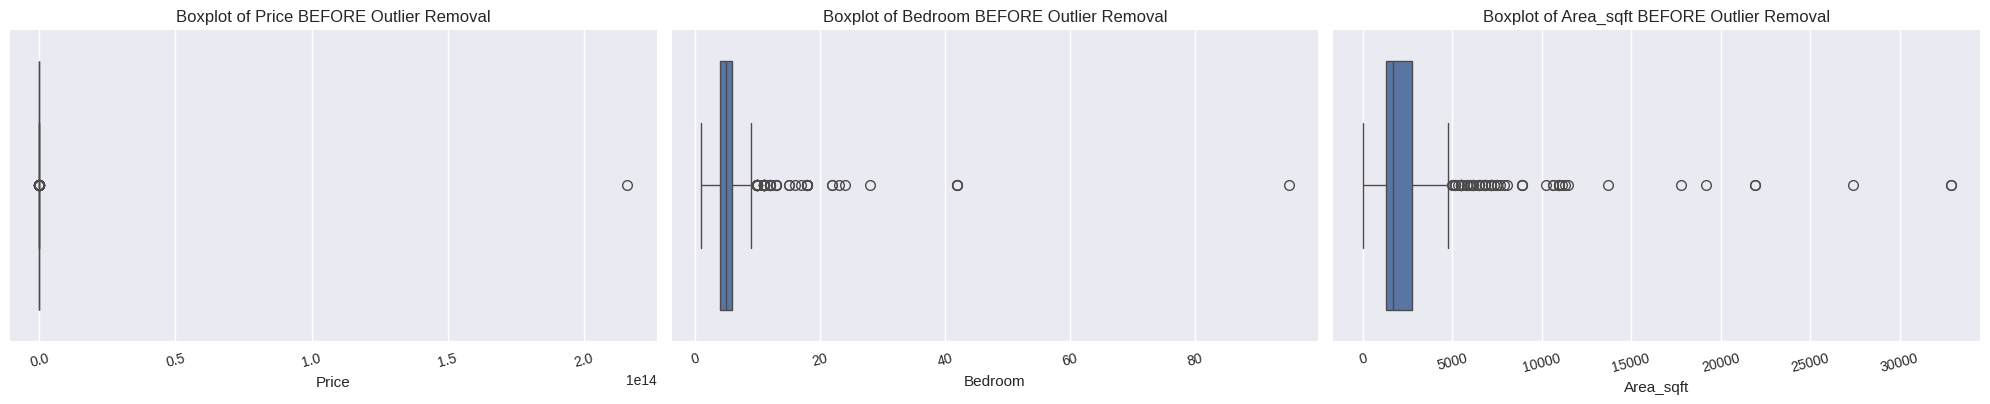

In [36]:
# --- 3. Boxplots BEFORE outlier removal ---
plt.figure(figsize=(20, 15))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_model[col])
    plt.title(f'Boxplot of {col} BEFORE Outlier Removal')
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [37]:
def get_outlier_bounds(data, col, factor=3):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return lower_bound, upper_bound


In [38]:
# --- 4. Removing Outliers ---
bounds = {}
for col in cols_to_check:
    bounds[col] = get_outlier_bounds(df_model, col, factor=5)

filter_condition = True
for col in cols_to_check:
    lower, upper = bounds[col]
    filter_condition = filter_condition & (df_model[col] >= lower) & (df_model[col] <= upper)
df_model = df_model[filter_condition]

print(len(df_model))

1095


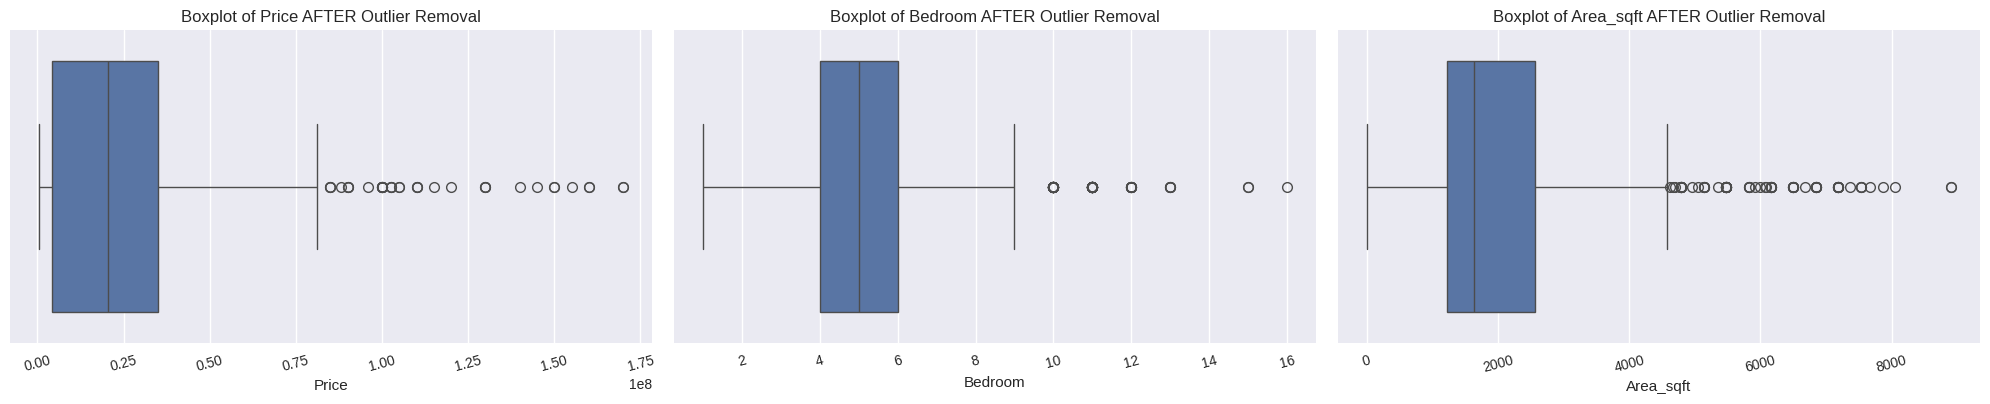

In [39]:

# --- 7. Boxplots AFTER cleaning ---
plt.figure(figsize=(20, 15))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_model[col])
    plt.title(f'Boxplot of {col} AFTER Outlier Removal')
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [40]:
# --- 3. Summary after cleaning and outlier removal ---

print("Summary Statistics after Cleaning and Outlier Removal:")
print(df_model[cols_to_check + ['Road_Width_ft', 'Amenities_Count']].describe())

Summary Statistics after Cleaning and Outlier Removal:
              Price      Bedroom    Area_sqft  Road_Width_ft  Amenities_Count
count  1.095000e+03  1095.000000  1095.000000    1095.000000      1095.000000
mean   2.543139e+07     5.614612  2130.301933      15.466667         4.600000
std    2.572631e+07     2.125704  1460.938190       5.045726         6.038481
min    5.000000e+05     1.000000     3.100000       3.000000         0.000000
25%    4.200000e+06     4.000000  1219.265625      13.000000         0.000000
50%    2.050000e+07     5.000000  1642.800000      14.000000         2.000000
75%    3.500000e+07     6.000000  2566.875000      16.000000         7.000000
max    1.700000e+08    16.000000  8898.500000      50.000000        30.000000


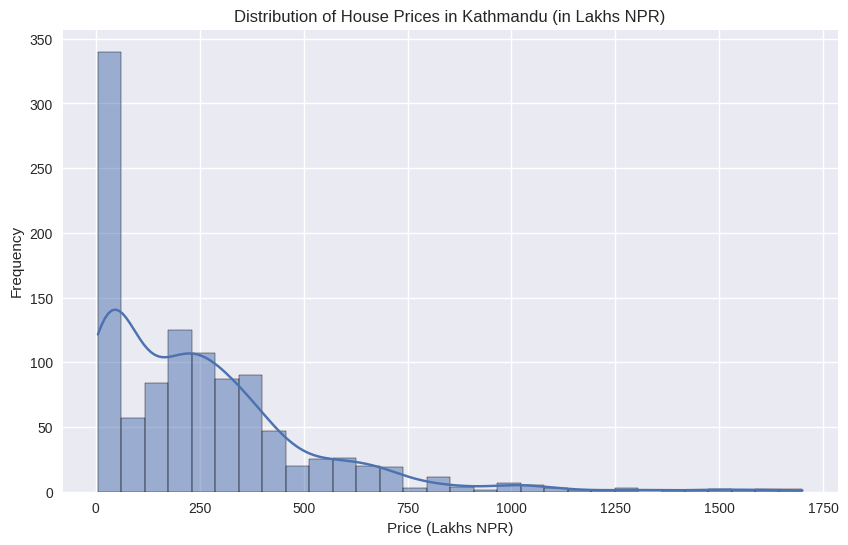

In [41]:
# Plotting the cleaned distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_model['Price'] / 100000, kde=True, bins=30)
plt.title('Distribution of House Prices in Kathmandu (in Lakhs NPR)')
plt.xlabel('Price (Lakhs NPR)')
plt.ylabel('Frequency')
plt.show()

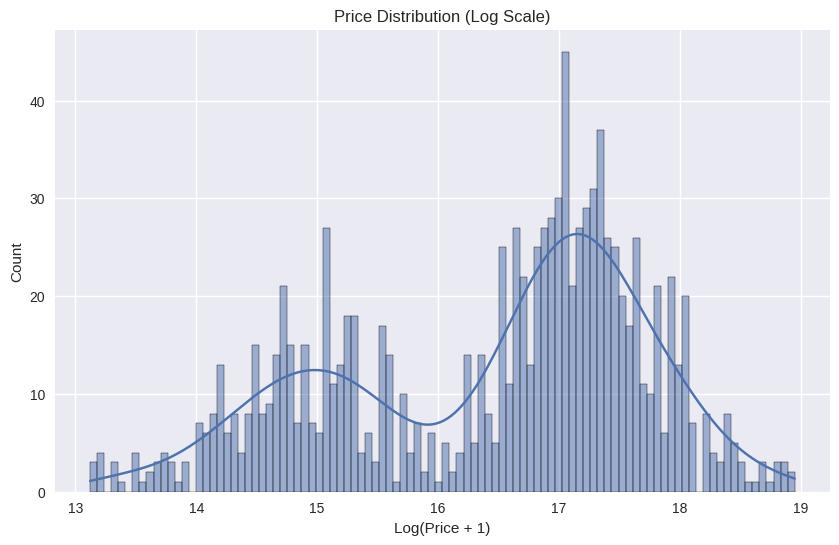

In [42]:

# Log scale distribution for better spread
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_model['Price']), bins=100, kde=True)
plt.title('Price Distribution (Log Scale)')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Count')
plt.show()

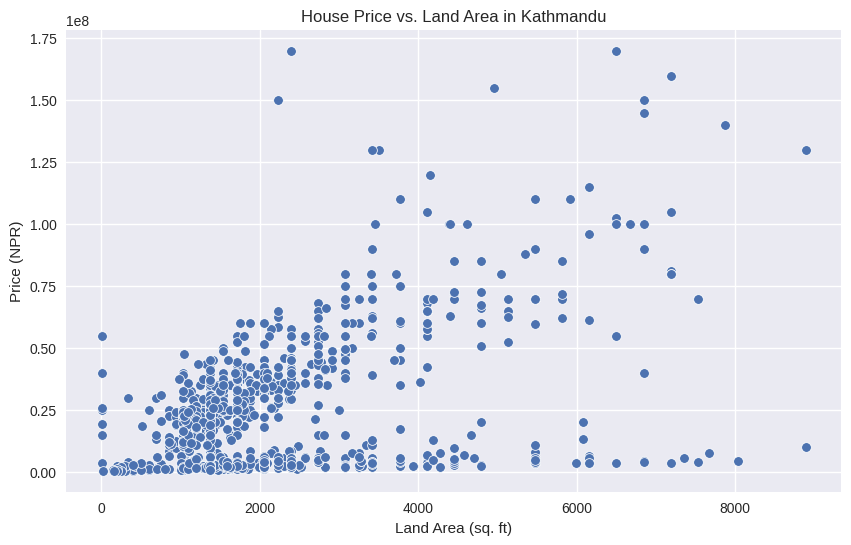

In [43]:
# Plot 2: Price vs. Land Area
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area_sqft', y='Price', data=df_model)
plt.title('House Price vs. Land Area in Kathmandu')
plt.xlabel('Land Area (sq. ft)')
plt.ylabel('Price (NPR)')
plt.show()

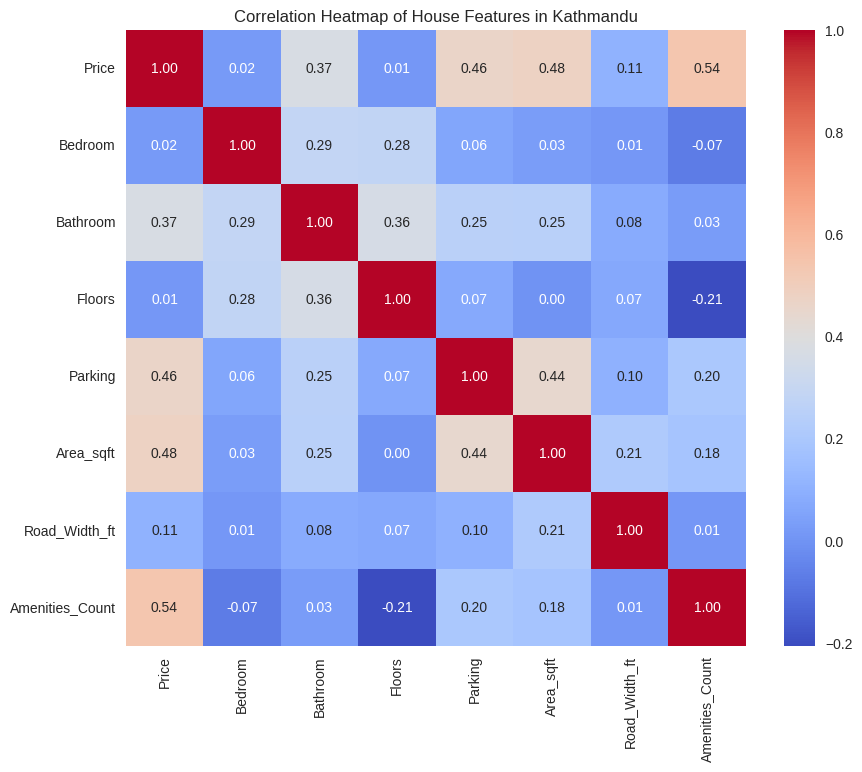

In [47]:
# Plot 3: Correlation Heatmap
numeric_cols = ['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking', 'Area_sqft', 'Road_Width_ft', 'Amenities_Count']
corr_matrix = df_model[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of House Features in Kathmandu')
plt.show()

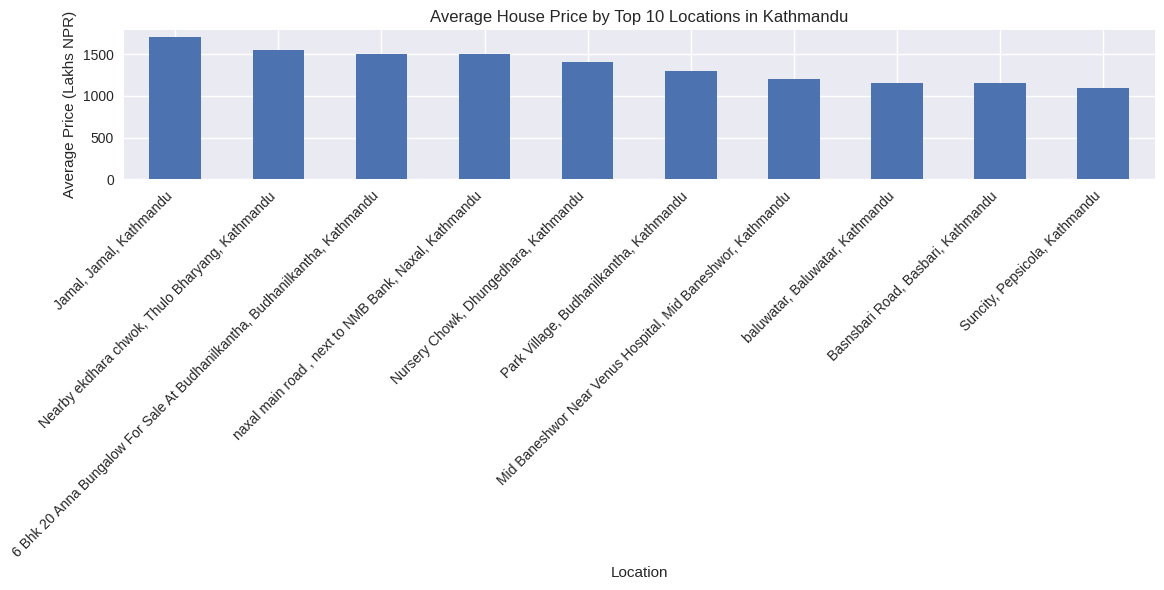

In [50]:
# Plot 4: Average Price by Location (Top 10) - in Lakhs
top_areas = df_model.groupby('Address')['Price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))

# Converting to lakhs
top_areas_lakhs = top_areas / 100000

top_areas_lakhs.plot(kind='bar')
plt.title('Average House Price by Top 10 Locations in Kathmandu')
plt.xlabel('Location')
plt.ylabel('Average Price (Lakhs NPR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
# Defining approximate coordinates for Kathmandu neighborhoods (based on common areas)
location_coords = {
    'Budhanilkantha': [27.776, 85.359],
    'Baluwatar': [27.727, 85.334],
    'Dhapasi': [27.744, 85.337],
    'Golfutar': [27.752, 85.356],
    'Banasthali': [27.707, 85.294],
    'Sukedhara': [27.737, 85.339],
    'Sitapaila': [27.708, 85.279],
    'Narephate': [27.708, 85.349],
    'Thankot': [27.681, 85.243],
    'Kalanki': [27.694, 85.281],
    'Kavresthali': [27.748, 85.298],
    'Pepsicola': [27.693, 85.374],
    'Kapan': [27.737, 85.362],
    'Mandikatar': [27.736, 85.344],
    'Hattigauda': [27.752, 85.344],
    'Maligaon': [27.716, 85.336],
    'Tokha': [27.760, 85.325],
    'Swayambhu': [27.715, 85.291],
    'Tarkeshwor': [27.743, 85.301],
    'Mhepi': [27.717, 85.298],
    'Pasikot': [27.766, 85.356],
    'Maharajgunj': [27.736, 85.333],
    'Raniban': [27.727, 85.287],
    'Manamaiju': [27.737, 85.311],
    'Goldhunga': [27.744, 85.294],
    'Syuchatar': [27.701, 85.271],
    'Thulo Bharyang': [27.707, 85.277],
    'Baniyatar': [27.731, 85.312]
}

# Creating a Folium map centered on Kathmandu
kathmandu_map = folium.Map(location=[27.7172, 85.3240], zoom_start=12)
marker_cluster = MarkerCluster().add_to(kathmandu_map)

# Adding markers for each house
for idx, row in df_model.iterrows():
    address = row['Address'].split(',')[0].strip()
    if address in location_coords:
        price_lakhs = row['Price'] / 100000
        folium.Marker(
            location=location_coords[address],
            popup=f"{address}: {price_lakhs:.2f} Lakhs NPR",
            icon=folium.Icon(color='blue' if price_lakhs < 500 else 'red')
        ).add_to(marker_cluster)

# Saving the map
kathmandu_map.save('kathmandu_price._map.html')
print("Interactive map saved as 'kathmandu_price._map.html'. Download and open in a browser.")

Interactive map saved as 'kathmandu_price._map.html'. Download and open in a browser.
